In [68]:
import numpy as np 
import pandas as pd 
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


import warnings 

warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [69]:
df=pd.read_csv("/international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [70]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [71]:
df.columns=["Month","Passengers"]
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [72]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [73]:
df.shape

(145, 2)

In [74]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [75]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [77]:
df=df[:144]
df.tail()


,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [79]:
df["Month"]=pd.to_datetime(df["Month"])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [81]:
print("Minimum Tarih :", df["Month"].min())
print("Maksimum Tarih :", df["Month"].max())

Minimum Tarih : 1949-01-01 00:00:00
Maksimum Tarih : 1960-12-01 00:00:00


In [82]:
df.index=df["Month"]
df.head()


,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [83]:
df.drop("Month",axis=1,inplace=True)
df.head()


,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [84]:
result_df=df.copy()

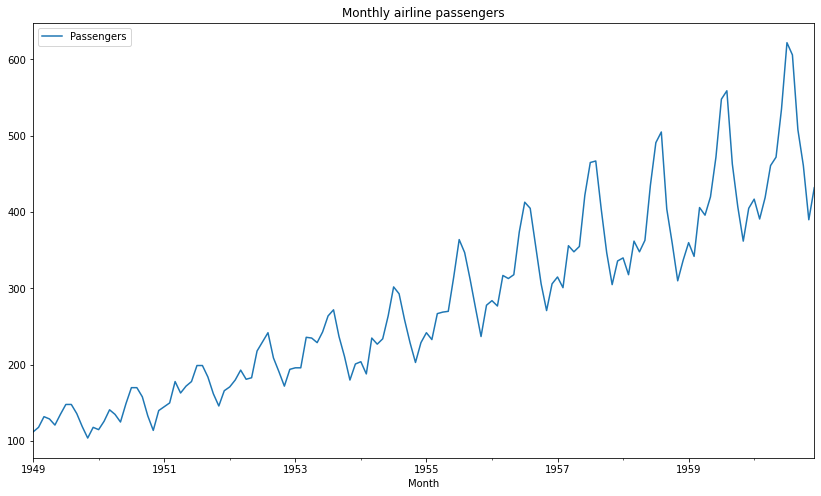

In [85]:
df.plot(figsize=(14,8),title='Monthly airline passengers');

In [86]:
data=df["Passengers"].values
data[0:5]
type(data[0:5])


numpy.ndarray

In [87]:
type(data[0])

numpy.float64

In [88]:
data=data.astype('float32')
type(data[0])

numpy.float32

In [89]:
data.shape

(144,)

In [90]:
data=data.reshape(-1,1)

In [91]:
data.shape

(144, 1)

In [92]:
def split_data(dataframe,test_size):
  position=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:position]
  test=dataframe[position:]
  return train,test,position

In [93]:
train,test,position=split_data(data,0.33)
print(train.shape,test.shape)

(96, 1) (48, 1)


In [94]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [95]:
train[0:5]


array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [96]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [97]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range (lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [98]:
lookback=1

In [99]:
X_train , y_train=create_features(train,lookback)
X_test , y_test=create_features(test,lookback)

In [100]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [101]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [102]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [103]:
model=Sequential()

In [104]:


model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1],lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode="min"),
           ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
           save_best_only=True,save_weights_only=False,verbose=1)]

In [107]:
history=model.fit(x=X_train,
                  y=y_train,
                  epochs=50,
                  batch_size=1,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/50
78/95 [=======================>......] - ETA: 0s - loss: 0.0111
Epoch 1: val_loss improved from inf to 0.03793, saving model to mymodel.h5
95/95 [==============================] - 2s 5ms/step - loss: 0.0136 - val_loss: 0.0379
Epoch 2/50
91/95 [===========================>..] - ETA: 0s - loss: 0.0194
Epoch 2: val_loss improved from 0.03793 to 0.02508, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0251
Epoch 3/50
85/95 [=========================>....] - ETA: 0s - loss: 0.0129
Epoch 3: val_loss improved from 0.02508 to 0.02056, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0206
Epoch 4/50
79/95 [=======================>......] - ETA: 0s - loss: 0.0066
Epoch 4: val_loss did not improve from 0.02056
95/95 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0215
Epoch 5/50
79/95 [=======================>......] - ETA: 0s - loss: 0.00

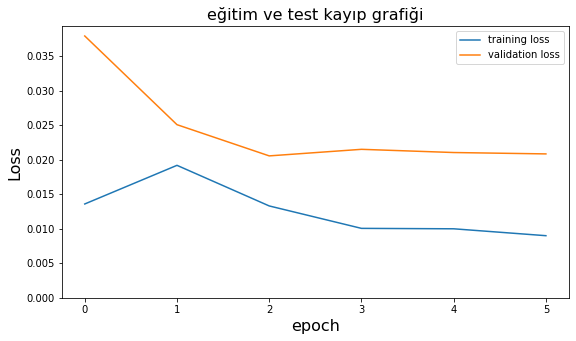

In [108]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('eğitim ve test kayıp grafiği',fontsize=16)
plt.show()

In [109]:
loss=model.evaluate(X_test,y_test,batch_size=1)
print("\n Test Loss: %.1f%%" % (100.0*loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0208

 Test Loss: 2.1%


In [110]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [111]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [112]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [113]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [114]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))


In [115]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 70754.953125
Test RMSE: 136808.046875


In [116]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [117]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [121]:
train_prediction_df=result_df[lookback:position]
train_prediction_df["Predicted"]=train_predict
train_prediction_df.head()

test_prediction_df=result_df[lookback+position:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,106508.570312
1957-03-01,356.0,103451.375000
1957-04-01,348.0,118692.429688
1957-05-01,355.0,116286.507812
1957-06-01,422.0,118391.695312


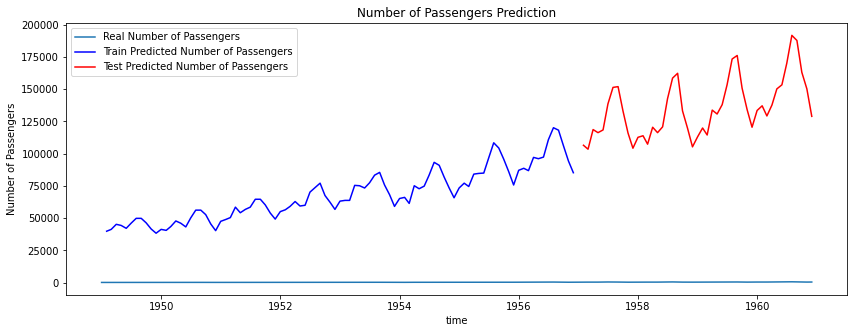

In [122]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"],color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"],color='red', label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()